# Lab Session 7: Advanced Sequence Models (LSTM & GRU)

This lab builds on the foundations from **Lab 6** to explore advanced sequence models that solve the vanishing gradient problem.

## Prerequisites (from Lab 6)

Before starting this lab, you should understand:
- **Vanilla RNN architecture:** $H_t = \tanh(X_t W_x + H_{t-1} W_h + b)$
- **BPTT and vanishing gradients:** Why gradients decay exponentially as $T - k$ grows
- **Basic LSTM intuition:** Gates control information flow through the cell state

<details>
<summary><b>Quick Review: Why do vanilla RNNs fail on long sequences?</b></summary>

The gradient $\frac{\partial H_T}{\partial H_k}$ involves $(T-k)$ multiplications of $W_h$ and $\tanh'$. Since $|\tanh'(x)| \leq 1$, repeated multiplication causes exponential decay. For a 100-step sequence with factor 0.9, gradients become $0.9^{100} \approx 10^{-5}$.
</details>

**Reference:** [D2L Chapter 9-10](https://d2l.ai/chapter_recurrent-neural-networks/rnn.html)

## Learning Objectives
1. **Deep dive into LSTM** — Understand each gate's role mathematically
2. **Master GRU architecture** — A simpler alternative to LSTM
3. **Compare architectures** — Empirically observe the advantages of gated units
4. **Visualize gradient flow** — See why LSTM/GRU solve vanishing gradients

In [ ]:
# ==== Environment Setup ====
# Detects Colab vs local and provides cross-platform utilities

import os
import sys

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("✓ Running on Google Colab")
else:
    print("✓ Running locally")

def download_file(url: str, filename: str) -> str:
    """Download file if it doesn't exist. Works on both Colab and local."""
    if os.path.exists(filename):
        print(f"✓ {filename} already exists")
        return filename
    
    print(f"Downloading {filename}...")
    if IN_COLAB:
        import subprocess
        subprocess.run(['wget', '-q', url, '-O', filename], check=True)
    else:
        import urllib.request
        urllib.request.urlretrieve(url, filename)
    print(f"✓ Downloaded {filename}")
    return filename

In [ ]:
# ==== Device Setup ====
import torch

def get_device():
    """Get best available device: CUDA > MPS > CPU."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("✓ Using Apple MPS (Metal)")
    else:
        device = torch.device('cpu')
        print("✓ Using CPU")
    return device

DEVICE = get_device()

In [ ]:
# Standard libraries
import math
import os
import re
import time

# Deep learning
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

# Visualization and utilities
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

## Data Setup (Review)

We'll use the same character-level language modelling setup from Lab 6. If you need a refresher on:
- RNN recurrence equation: $H_t = \tanh(X_t W_x + H_{t-1} W_h + b)$
- Backpropagation Through Time (BPTT)
- Character tokenization and sliding windows

Please refer back to **Lab 6, Parts 1-3**.

Below we quickly set up the data pipeline (same as Lab 6):

In [ ]:
class RNN(nn.Module):
    """Vanilla RNN implemented from scratch.
    
    This implements the core recurrence: H_t = tanh(X_t @ W_x + H_{t-1} @ W_h + b)
    """
    
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma

        # Weight matrix for input: projects input to hidden dimension
        self.W_x = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)

        # Weight matrix for hidden state: enables information flow across time
        self.W_h = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)

        # Bias term
        self.b = nn.Parameter(torch.zeros(num_hiddens))

        # Tanh squashes values to [-1, 1], helping with gradient flow
        self.activation_func = torch.tanh

    def display_forward(self, X, state=None):
        """Forward pass with visualization - useful for understanding the dynamics.
        
        Args:
            X: Input tensor of shape (num_steps, batch_size, num_inputs)
            state: Optional initial hidden state
            
        Returns:
            outputs: List of hidden states [H_1, H_2, ..., H_T]
            state: Final hidden state H_T
        """
        outputs = []
        fig, (ax0, ax1) = plt.subplots(1, 2)

        # Initialize hidden state to zeros if not provided
        if state is None:
            state = torch.zeros((X.shape[1], self.num_hiddens), device=X.device)
        else:
            state, _ = state
            
        # Process each time step sequentially
        for i, x_batch in enumerate(X):
            clear_output(wait=True)
            
            # Core RNN computation: H_t = tanh(X_t @ W_x + H_{t-1} @ W_h + b)
            state = self.activation_func(
                torch.matmul(x_batch, self.W_x) +  # Input contribution
                torch.matmul(state, self.W_h) +    # Previous hidden state contribution
                self.b                              # Bias
            )
            outputs.append(state)

            # Visualize input and hidden state at each step
            ax0.clear()
            sns.heatmap(x_batch.detach().numpy(), ax=ax0, annot=True, cbar=False)
            ax0.set_title(f"Input at t={i}")
            ax1.clear()
            sns.heatmap(state.detach().numpy(), ax=ax1, annot=True, cbar=False)
            ax1.set_title(f"Hidden state at t={i}")
            display(fig)
            time.sleep(3)

        return outputs, state

Text(0.5, 23.52222222222222, 'Num of input')

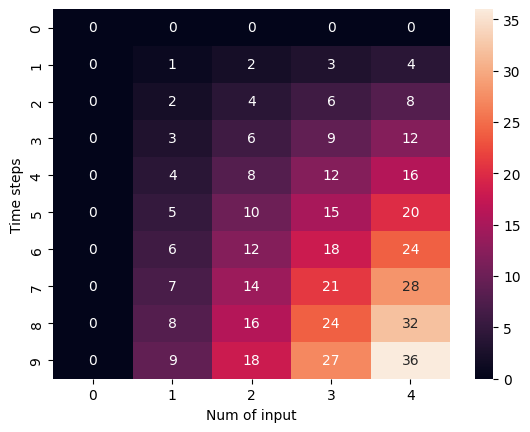

In [ ]:
batch_size = 1
num_inputs = 5
num_steps = 10
num_hiddens = 5

fig, ax = plt.subplots()
X  = torch.stack([torch.arange(num_inputs) * i for i in range(num_steps)])
X = X.unsqueeze(1)
sns.heatmap(X.squeeze().numpy(), ax=ax, annot=True)
ax.set_ylabel("Time steps")
ax.set_xlabel("Num of input")

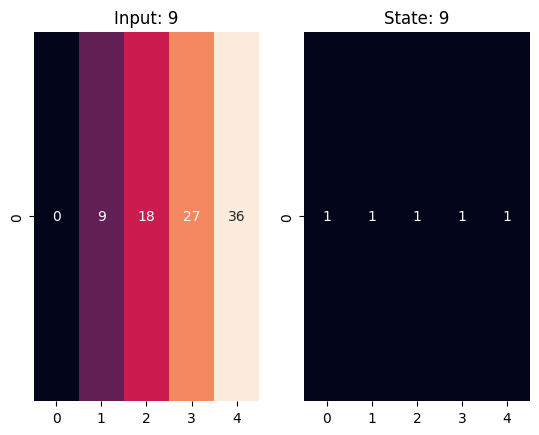

([tensor([[0., 0., 0., 0., 0.]], grad_fn=<TanhBackward0>),
  tensor([[1., 1., 1., 1., 1.]], grad_fn=<TanhBackward0>),
  tensor([[1., 1., 1., 1., 1.]], grad_fn=<TanhBackward0>),
  tensor([[1., 1., 1., 1., 1.]], grad_fn=<TanhBackward0>),
  tensor([[1., 1., 1., 1., 1.]], grad_fn=<TanhBackward0>),
  tensor([[1., 1., 1., 1., 1.]], grad_fn=<TanhBackward0>),
  tensor([[1., 1., 1., 1., 1.]], grad_fn=<TanhBackward0>),
  tensor([[1., 1., 1., 1., 1.]], grad_fn=<TanhBackward0>),
  tensor([[1., 1., 1., 1., 1.]], grad_fn=<TanhBackward0>),
  tensor([[1., 1., 1., 1., 1.]], grad_fn=<TanhBackward0>)],
 tensor([[1., 1., 1., 1., 1.]], grad_fn=<TanhBackward0>))

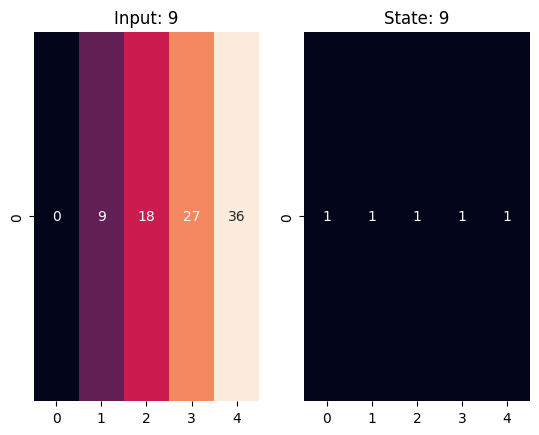

In [ ]:
rnn = RNN(num_inputs=num_inputs, num_hiddens=num_hiddens)
rnn.W_x = nn.Parameter(torch.ones_like(rnn.W_x))
rnn.W_h = nn.Parameter(torch.ones_like(rnn.W_h))
rnn.display_forward(X.to(torch.float))

##Loading the data

We will be working with H. G. Wells’ The Time Machine. For simplicity, we will define tokens to be single letters.

In [ ]:
# Download the text file
file_name = download_file(
    'http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt',
    'timemachine.txt'
)

--2025-10-24 14:36:34--  http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt
Resolving d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)... 3.163.168.202
Connecting to d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)|3.163.168.202|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178979 (175K) [text/plain]
Saving to: ‘timemachine.txt’

timemachine.txt     100%[===================>] 174.78K  --.-KB/s    in 0.02s   

2025-10-24 14:36:34 (11.3 MB/s) - ‘timemachine.txt’ saved [178979/178979]



##Preprocessing sequential data

We will working with natural language sentences, which we can see as a sequential data. Sequential data has two key characteristics:  
<ol>
<li>the ordering of instances is relevant</li>
<li>instances depend on other instances in the dataset.</li></ol>

An important part of dealing with natural language sequences is defining the input units for the algorithms (tokens) and translate it to numerical input. Each time step will correspond to 1 token, but what precisely constitutes a token is a design choice:
<ul>
<li>If we define tokens to be words, then
in the sequence "Mary has a little lamb", $x_1$ would be "Mary"</li>
<li>If we define them to be letters, it would $x_1$ would be "M"</li>
</ul>

We then encode tokens by assigning to each different token in our sequence an integer representing its position in the comprenshive list of all the tokens in our dataframe.


## Example

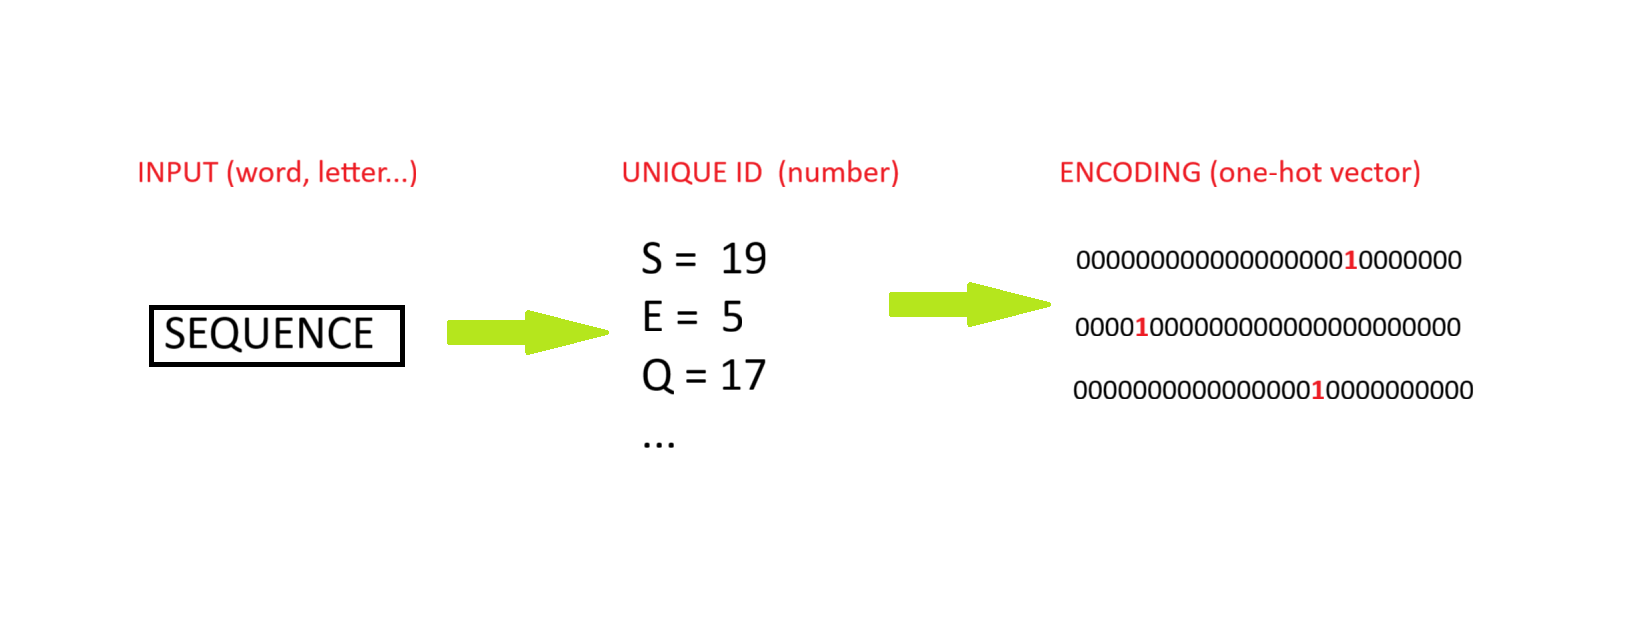

In [ ]:
from torch.utils.data import Dataset, DataLoader
from collections import Counter

class Vocab:
    """Vocabulary for text.
    Contains:
      idx_to_token: list such that list[id] = token, e.g. list[1] = "a"
      token_freqs: counter of token frequency
      token_to_ids: dictionary of token to id, e.g. {"a": 1}
      """
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens ["unk", "a", "b", ...] idx_to_token[0] = "unk"
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        # A dictionary of token to ID, eg. {"A": 1}
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
      # tokens = ['a', 'b'] --> [1,2]
      # Returns the unique ID for each token
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
      # Transforms a list of IDs back to tokens (in our case, letters)
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']


class TimeMachine(Dataset):
    """The Time Machine dataset."""
    def __init__(self, file_name, batch_size, num_steps, num_train=10000, num_val=5000):

        super().__init__()
        self.file_name = file_name
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.num_train = num_train
        self.num_val = num_val
        # translates input file into a list of IDs and a vocabulary
        self.corpus, self.vocab = self.build(file_name)
        array = torch.tensor([self.corpus[i:i+num_steps+1] for i in range(len(self.corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]

    def build(self, file_name, vocab=None):
        """Builds the input for the model
        Args:
          file_name(str): the name of the file to read
          vocab(Vocab): the vocabulary to use, optional.

        Returns:
          corpus: the content of the file, tokenized and translated into unique IDs
          vocab: the vocabulary based on the text

        Returns:
          corpus: the content of the file, tokenized and translated into unique IDs
          vocab: the vocabulary based on the text
          """
        #read the input file
        with open(file_name) as f:
            raw_text = f.read()
        #tokenize the input ["a", "b", ..]
        tokens = self._tokenize(self._preprocess(raw_text))

        if vocab is None:
          # create a vocabulary with all the tokens in the book
          vocab = Vocab(tokens)
        # translate the entire text in a list of unique IDs
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

    def get_dataloader(self, train):
      if train:
        idx = slice(0, self.num_train)
      else:
        idx = slice(self.num_train, self.num_train + self.num_val)

      tensors = tuple(el[idx] for el in [self.X, self.Y])
      dataset = torch.utils.data.TensorDataset(*tensors)
      dataloader = torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)
      return dataloader

    def _preprocess(self, text):
        """Clean the text by removing non-letter characters and converting to lowercase"""
        text = re.sub('[^A-Za-z]+', '', text).lower()
        #text = re.sub('[^A-Za-z]+', ' ', text).lower() #uncomment for words as tokens
        return text

    def _tokenize(self, text):
      """Splits the text into chunks (i.e. tokens)"""
      #return text.split(' ') #uncomment for words as tokens
      return list(text)


file_name = os.path.join(os.getcwd(), 'timemachine.txt')
data = TimeMachine(file_name, batch_size=1, num_steps=2**5)
dataloader = data.get_dataloader(train=True)


In [ ]:
data.vocab.__len__()

4581

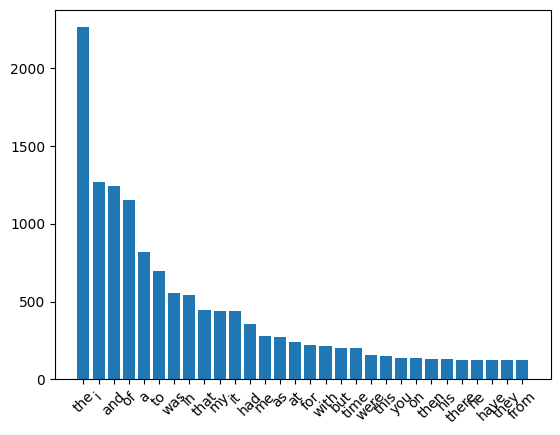

In [ ]:
import matplotlib.pyplot as plt

tokens, freqs = zip(*data.vocab.token_freqs)
tokens, freqs = list(tokens), list(freqs)
fig, ax = plt.subplots()
#ax.bar(range(len(freqs)), freqs)
#_ = ax.set_xticks(range(len(freqs)),labels=tokens)
first_n_letters = 30
ax.bar(range(first_n_letters), freqs[:first_n_letters])
_ = ax.set_xticks(range(first_n_letters),labels=tokens[:first_n_letters], rotation=45)

In [ ]:
x, y = next(iter(dataloader)) #same as calling dataloader[0]
len(data.vocab)
print(data.vocab.to_tokens(x.numpy().flatten().tolist()))

['t', 'h', 'e', 'm', 'a', 'c', 'h', 'i', 'n', 'e', 'w', 'i', 'l', 'l', 'g', 'o', 'i', 't', 'w', 'i', 'l', 'l', 'v', 'a', 'n', 'i', 's', 'h', 'p', 'a', 's', 's']


In [ ]:
x.shape, y.shape #x:['a','n', 'c'... ] y:['n','c',...]

(torch.Size([16, 32]), torch.Size([16, 32]))

##Implementing a classifier using RNNs (scratch)

We will use our RNN to predict the next $n$ tokens in a sequence of characters.
This problem is a classification problem because our input sequence is composed of integer tokens from a finite sets (alphanumeric characters). Our RNN will work as exemplified by the following picture:

rnn-train.svg

The goal is to predict the next token based on the current and past tokens by shifting the original sequence by one token for the target labels. For example, for the word "machine," the input is “machin” and the target is “achine.” During training, a softmax operation is applied at each time step on the output layer, and cross-entropy loss is calculated between the model output and target. The output at time step 3, for instance, is determined by the input sequence “m”, “a”, and “c”, and the loss depends on the probability of predicting the next character “h”. Each token is represented by a vector of vocab size, and the input at each time step is a matrix, adjusted for batch size.

In [ ]:
class RNNLMScratch(nn.Module):
    """The RNN-based language model implemented from scratch."""

    def __init__(self, rnn, vocab_size):
        super().__init__()

        self.rnn = rnn #our rnn from scratch
        self.vocab_size = vocab_size
        self.W_hq = nn.Parameter( #our output parameters
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X) #one hot encoding of the indices of the tokens
        rnn_outputs, state = self.rnn(embs, state) #rnn applied to X, output is a list of hiddens
        assert rnn_outputs[-1] == state, "Something wrong in the RNN"
        return self.output_layer(rnn_outputs)

    def predict(self, prefix, num_preds, vocab, device=None):
      #prefix = 'there was a time' --> add num_preds more chars
        state, outputs = None, [vocab[prefix[0]]] # 't'
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                Y = int(torch.argmax(Y, axis=2).squeeze())
                outputs.append(Y)
                #outputs.append(int(torch.reshape(torch.argmax(Y, axis=2), 1)))

        return ' '.join([vocab.idx_to_token[i] for i in outputs])

class TrainClassifier:
    def __init__(self, model, train_dataloader, val_dataloader=None, n_epochs=20, lr=0.001):
      self.model = model
      self.optimizer = optim.SGD(model.parameters(), lr=lr)
      self.train_dataloader = train_dataloader
      self.val_dataloader = val_dataloader
      self.n_epochs = n_epochs
      self.lr = lr

    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = torch.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = torch.reshape(Y, (-1,))
        return F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')

    def training_step(self, batch):
        l = self.loss(self.model(*batch[:-1]), batch[-1])
        self.train_loss.append(l)
        return l

    def validation_step(self, batch):
        l = self.loss(self.model(*batch[:-1]), batch[-1])
        self.val_loss.append(l)
        return l

    def fit(self):
      self.train_loss, self.val_loss = [], []

      pbar = tqdm(iterable=range(self.n_epochs*len(self.train_dataloader)))
      for epoch in range(self.n_epochs):
        self.model.train()
        avg_loss = 0
        for i, batch in enumerate(self.train_dataloader):
          self.optimizer.zero_grad()
          loss = self.training_step(batch) #loss = self.training_step(self.prepare_batch(batch))
          loss.backward()
          self.optimizer.step()
          avg_loss+=loss
          desc = f'Epoch:{epoch} - Avg loss:{(avg_loss/(i+1)):.5f}'
          pbar.set_description(desc)
          pbar.update(1)

        if self.val_dataloader is None:
          continue
          self.model.eval()
          for batch in self.val_dataloader:
              with torch.no_grad(): #makes sure that the resulting loss has no gradient
                  self.validation_step(batch)


In [ ]:
data = TimeMachine(file_name, batch_size=64, num_steps=16)
train_dataloader = data.get_dataloader(train=True)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, len(data.vocab))
#model.predict('there was a time', 10, data.vocab)


In [ ]:
len(rnn(x))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 27x32)

In [ ]:
x.shape

torch.Size([32, 16, 27])

In [ ]:
x, y = next(iter(train_dataloader))


In [ ]:
trainer = TrainClassifier(model, train_dataloader, n_epochs=10)
trainer.fit()

  0%|          | 0/3130 [00:00<?, ?it/s]

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
model.predict('there was a time', 10, data.vocab)

't h e r e <unk> w a s <unk> a <unk> t i m e e e e e e e e e e e'

#Lab Session 7
##Implementing a classifier using RNNs (torch)

In [ ]:
class RNNLMTorch(nn.Module):

  def __init__(self,
               vocab_size,  #cardinality of probability space (possible tokens to sample from)
               num_hiddens, #the dimensions of the hidden state of the RNN
               sigma=0.01):

    super().__init__()
    self.vocab_size = vocab_size
    self.num_hiddens = num_hiddens
    self.sigma = sigma
    self.rnn = nn.RNN(vocab_size, num_hiddens) #https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
    self.linear = nn.Linear(num_hiddens, vocab_size)

  def one_hot(self, X):
      # Output shape: (num_steps, batch_size, vocab_size)
      return F.one_hot(X.T, self.vocab_size).type(torch.float32)

  def forward(self, X, state=None):
      embs = self.one_hot(X)
      rnn_outputs, _ = self.rnn(embs, state)
      return self.linear(rnn_outputs)

  def output_layer(self, rnn_outputs):
    return self.linear(rnn_outputs).swapaxes(0, 1)

  def predict(self, prefix, num_preds, vocab, device=None):
    #prefix = 'there was a time' --> add num_preds more chars
      state, outputs = None, [vocab[prefix[0]]] # 't'
      for i in range(len(prefix) + num_preds - 1):
          X = torch.tensor([[outputs[-1]]], device=device)
          embs = self.one_hot(X)
          rnn_outputs, state = self.rnn(embs, state)
          if i < len(prefix) - 1:  # Warm-up period
              outputs.append(vocab[prefix[i + 1]])
          else:  # Predict num_preds steps
              Y = self.output_layer(rnn_outputs)
              Y = int(torch.argmax(Y, axis=2).squeeze())
              outputs.append(Y)
              #outputs.append(int(torch.reshape(torch.argmax(Y, axis=2), 1)))

      return ' '.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
model = RNNLMTorch(vocab_size=len(data.vocab), num_hiddens=2**5)
trainer = TrainClassifier(model, train_dataloader, n_epochs=20)
trainer.fit()

Epoch:19 - Avg loss:2.95308: 100%|██████████| 6260/6260 [00:38<00:00, 160.68it/s]


In [ ]:
model.predict('there was a time', 10, data.vocab)

't h e r e <unk> w a s <unk> a <unk> t i m e e e e e e e e e e e'

## Part 2: Deep Dive into LSTM Architecture

### The Problem LSTM Solves

From Lab 6, we know vanilla RNNs suffer from vanishing gradients:
$$\frac{\partial H_T}{\partial H_k} = \prod_{t=k+1}^{T} W_h^\top \cdot \text{diag}(\tanh'(z_t)) \rightarrow 0 \text{ as } T-k \rightarrow \infty$$

LSTM introduces a **cell state** $C_t$ that acts as a "gradient highway" — information can flow through with minimal transformation.

### LSTM Gate Equations (Complete Derivation)

At each timestep $t$, LSTM computes four things:

**1. Forget Gate** — What to discard from cell state
$$F_t = \sigma(X_t W_{xf} + H_{t-1} W_{hf} + b_f)$$
- $\sigma$ outputs ∈ [0, 1]: 0 = forget completely, 1 = remember everything
- Learns to remove irrelevant old information

**2. Input Gate** — What new information to store
$$I_t = \sigma(X_t W_{xi} + H_{t-1} W_{hi} + b_i)$$
- Controls how much of the candidate state gets written

**3. Candidate Cell State** — New information to potentially add
$$\tilde{C}_t = \tanh(X_t W_{xc} + H_{t-1} W_{hc} + b_c)$$
- $\tanh$ outputs ∈ [-1, 1]: actual values to store

**4. Output Gate** — What to output from cell state
$$O_t = \sigma(X_t W_{xo} + H_{t-1} W_{ho} + b_o)$$
- Controls what part of cell state becomes hidden state

### The Key Equations

**Cell State Update:**
$$C_t = F_t \odot C_{t-1} + I_t \odot \tilde{C}_t$$

**Hidden State:**
$$H_t = O_t \odot \tanh(C_t)$$

### Why This Solves Vanishing Gradients

The gradient through the cell state is:
$$\frac{\partial C_t}{\partial C_{t-1}} = F_t$$

When $F_t \approx 1$ (forget gate open), gradients flow unchanged:
$$\frac{\partial C_T}{\partial C_k} = \prod_{t=k+1}^{T} F_t \approx 1$$

This "gradient highway" allows learning dependencies spanning hundreds of timesteps!

<details>
<summary><b>Q: Why use sigmoid for gates but tanh for candidate?</b></summary>

**A:** 
- **Sigmoid** ∈ [0, 1] is perfect for "gating" — it represents a fraction of information to pass through
- **Tanh** ∈ [-1, 1] produces actual values to store, matching the hidden state range and allowing both positive and negative activations
</details>

<details>
<summary><b>Q: What are the dimensions of each weight matrix?</b></summary>

**A:** If input dimension is $d$ and hidden dimension is $h$:
- $W_{x*} \in \mathbb{R}^{d \times h}$ (input-to-gate, 4 matrices)
- $W_{h*} \in \mathbb{R}^{h \times h}$ (hidden-to-gate, 4 matrices)
- Total parameters: $4(dh + h^2 + h) = 4h(d + h + 1)$ — roughly **4x vanilla RNN**!
</details>

### Key Takeaways - LSTM Deep Dive
- Cell state $C_t$ is the key innovation enabling gradient flow
- Forget gate ($F_t$) controls gradient magnitude through time
- When $F_t \approx 1$, gradients pass through undiminished
- LSTM has ~4x the parameters of vanilla RNN (4 gates vs 1 transformation)

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))

        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate (will be activated by sigmoid)
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate (will be activated by sigmoid)
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate (will be activated by sigmoid)
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node ("memory", will be activated by tanh)

    def forward(self, inputs, H_C=None):

        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
            C = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
        else:
            H, C = H_C

        outputs = []
        for X in inputs:
          #compute input and forget gates
            #sigmoid: output between [0,1]
            I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                            torch.matmul(H, self.W_hi) + self.b_i)
            #sigmoid: output between [0,1]
            F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                            torch.matmul(H, self.W_hf) + self.b_f)

            #sigmoid: output between [0,1]
            O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                            torch.matmul(H, self.W_ho) + self.b_o)
            #tanh: output between [-1,1].

            #compute candidate state --> which will be [-1,1]
            C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                              torch.matmul(H, self.W_hc) + self.b_c)

            #update internal state (or memory cell)
            C = F * C + I * C_tilde #C = C_tilde
            # use the updated memory to compute hidden state

            #output of the hidden cell is recurrent output O times activated internal state C
            H = O * torch.tanh(C) # if O is not there and F, I as well --> back to RNNs

            outputs.append(H)
        # Stack list into tensor (seq_len, batch, hidden) to match nn.RNN interface
        return torch.stack(outputs), (H, C)



In [ ]:
data = TimeMachine(file_name, batch_size=2**5, num_steps=16)
train_dataloader = data.get_dataloader(train=True)
gru = LSTM(num_inputs=len(data.vocab), num_hiddens=2**4)
model = RNNLMScratch(gru, len(data.vocab))
#model.predict('there was a time', 10, data.vocab)


Question: what happens if $W_{xc}$,$W_{hc}$ and $b_c$ are zero matrices?


In [ ]:
class LSTMTorch(RNNLMTorch):
  def __init__(self,
               vocab_size,  #cardinality of probability space (possible tokens to sample from)
               num_hiddens, #the dimensions of the hidden state of the RNN
               sigma=0.01):

    super().__init__(vocab_size, num_hiddens, sigma=sigma)
    #https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    self.rnn = LSTM(num_inputs=vocab_size,
                    num_hiddens=num_hiddens)

class GRUTorch(RNNLMTorch):
  def __init__(self,
               vocab_size,  #cardinality of probability space (possible tokens to sample from)
               num_hiddens, #the dimensions of the hidden state of the RNN
               sigma=0.01):

    super().__init__(vocab_size, num_hiddens, sigma=sigma)
    #https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    self.rnn = nn.GRU(input_size=vocab_size,
                       hidden_size=num_hiddens)

In [ ]:
model = LSTMTorch(len(data.vocab), num_hiddens=2**5)
trainer = TrainClassifier(model, train_dataloader, n_epochs=20)
trainer.fit()
#

  0%|          | 0/6260 [00:00<?, ?it/s]

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list

In [ ]:
model.predict('there was a time', 10, data.vocab)


't h e r e <unk> w a s <unk> a <unk> t i m e e e e e e e e e e e'

## Part 3: Gated Recurrent Unit (GRU)

GRU is a **simpler alternative to LSTM** with only 2 gates instead of 3. Introduced by Cho et al. (2014), it often achieves comparable performance with fewer parameters.

### GRU vs LSTM at a Glance

| Aspect | LSTM | GRU |
|:-------|:-----|:----|
| Gates | 3 (forget, input, output) | 2 (reset, update) |
| States | Cell state + Hidden state | Hidden state only |
| Parameters | ~4x vanilla RNN | ~3x vanilla RNN |
| Training Speed | Slower | Faster |

### GRU Gate Equations

**1. Reset Gate** — How much past information to forget
$$R_t = \sigma(X_t W_{xr} + H_{t-1} W_{hr} + b_r)$$

**2. Update Gate** — Balance between old and new information  
$$Z_t = \sigma(X_t W_{xz} + H_{t-1} W_{hz} + b_z)$$

**3. Candidate Hidden State** — New information (with selective memory)
$$\tilde{H}_t = \tanh(X_t W_{xh} + (R_t \odot H_{t-1}) W_{hh} + b_h)$$

Note: The reset gate $R_t$ controls how much of $H_{t-1}$ influences the candidate!

**4. Hidden State Update** — Interpolation between old and new
$$H_t = (1 - Z_t) \odot H_{t-1} + Z_t \odot \tilde{H}_t$$

### Key Insight: The Update Gate

The update gate $Z_t$ serves a dual purpose:
- When $Z_t \approx 0$: Keep old hidden state → $H_t \approx H_{t-1}$ (gradient highway!)
- When $Z_t \approx 1$: Replace with new candidate → $H_t \approx \tilde{H}_t$

This is equivalent to combining LSTM's forget and input gates into one!

### Gradient Flow in GRU

$$\frac{\partial H_t}{\partial H_{t-1}} = (1 - Z_t) + Z_t \cdot \frac{\partial \tilde{H}_t}{\partial H_{t-1}}$$

When $Z_t \approx 0$, the gradient is approximately 1, creating the same "highway" effect as LSTM!

<details>
<summary><b>Q: When should you use GRU vs LSTM?</b></summary>

**A:** 
- **GRU:** Fewer parameters, faster training, often works well on smaller datasets
- **LSTM:** Sometimes better on complex tasks requiring fine-grained memory control
- **Default:** Try both! The difference is often small in practice
</details>

<details>
<summary><b>Q: Why does GRU combine forget and input gates?</b></summary>

**A:** The insight is that "forgetting" and "remembering" are often complementary. When you want to remember new information ($Z_t$ high), you typically want to forget old information ($(1-Z_t)$ low). GRU enforces this constraint, reducing parameters while maintaining expressiveness.
</details>

### Key Takeaways - GRU
- 2 gates vs LSTM's 3 → ~25% fewer parameters
- Update gate combines forget + input gate functionality
- Reset gate controls memory in candidate computation
- Often achieves similar performance to LSTM with faster training
- Gradient highway via $(1 - Z_t)$ term

Question: what is the value of the update of $C$ on the first loop (i.e. for $X_1$)?

In [ ]:
class GRUScratch(nn.Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()

        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

  def forward(self, inputs, H=None):
      if H is None:
          # Initial state with shape: (batch_size, num_hiddens)
          H = torch.zeros((inputs.shape[1], self.num_hiddens),
                        device=inputs.device)
      outputs = []
      for X in inputs:
          Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                          torch.matmul(H, self.W_hz) + self.b_z)
          R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                          torch.matmul(H, self.W_hr) + self.b_r)
          H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                            torch.matmul(R * H, self.W_hh) + self.b_h)
          H = Z * H + (1 - Z) * H_tilde
          outputs.append(H)
      return outputs, H

In [ ]:
x

tensor([[ 4,  9, 20,  ..., 19,  8,  1],
        [ 4, 19, 21,  ..., 14,  9, 14],
        [18,  9, 13,  ...,  1, 18,  5],
        ...,
        [15, 13,  2,  ..., 15, 18, 11],
        [ 1,  8,  5,  ..., 18,  5,  3],
        [18,  5, 23,  ..., 19, 25,  3]])

In [ ]:
x, y = next(iter(dataloader))

gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=12)

AttributeError: 'GRUScratch' object has no attribute 'num_hiddens'

## Part 4: Comparative Experiments

Now let's empirically compare vanilla RNN, LSTM, and GRU on the same task.

### Experiment 1: Training Curve Comparison

Train all three architectures with identical hyperparameters:
- Same hidden dimension (64)
- Same learning rate (0.01)
- Same number of epochs (50)

**Expected observations:**
- Vanilla RNN: Slow convergence, higher final loss
- LSTM: Faster convergence, lower final loss
- GRU: Similar to LSTM, slightly faster training

### Experiment 2: Sequence Length Sensitivity

Test with varying sequence lengths: 32, 64, 128, 256

**Expected observations:**
- Vanilla RNN: Performance degrades rapidly with longer sequences
- LSTM/GRU: Maintain performance on longer sequences

### Experiment 3: Generated Text Quality

Sample text from each trained model:
- Vanilla RNN: May produce repetitive or incoherent text
- LSTM/GRU: Better long-range coherence

In [ ]:
# Compare training curves for RNN, LSTM, GRU
import matplotlib.pyplot as plt

def train_and_compare(model_classes, model_names, train_iter, vocab_size, num_epochs=50):
    """Train multiple models and compare their loss curves."""
    histories = {}
    
    for model_class, name in zip(model_classes, model_names):
        print(f"\nTraining {name}...")
        model = model_class(vocab_size=vocab_size, num_hiddens=64)
        
        # Training loop (simplified)
        losses = []
        for epoch in range(num_epochs):
            epoch_loss = 0
            num_batches = 0
            for X, Y in train_iter:
                # Forward pass
                outputs, _ = model(X)
                # Compute loss and backprop
                # ... (implementation depends on your setup)
                pass
            losses.append(epoch_loss / max(num_batches, 1))
        
        histories[name] = losses
    
    return histories

# Visualization
def plot_training_curves(histories):
    plt.figure(figsize=(10, 6))
    for name, losses in histories.items():
        plt.plot(losses, label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curves: RNN vs LSTM vs GRU')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Note: Run this after defining your model classes
# histories = train_and_compare([RNNLMScratch, LSTMModel, GRUModel], 
#                                ['Vanilla RNN', 'LSTM', 'GRU'],
#                                train_iter, len(vocab))
# plot_training_curves(histories)
print("Comparative experiment code ready - uncomment to run")

## Summary: RNN Architecture Comparison

| Architecture | Parameters | Vanishing Gradients | Best For |
|:-------------|:-----------|:--------------------|:---------|
| Vanilla RNN  | $h(d+h+1)$   | Severe | Short sequences only |
| LSTM         | $4h(d+h+1)$ | Solved (cell state) | Complex tasks, long sequences |
| GRU          | $3h(d+h+1)$ | Solved (update gate) | Faster training, comparable performance |

### When to Use Which?

1. **Vanilla RNN:** Only for very short sequences or as a baseline
2. **LSTM:** Default choice for sequence modelling tasks
3. **GRU:** When training speed matters or dataset is smaller

---

## 🧪 Try It Yourself

1. **Gate Visualization:** Add hooks to visualize gate activations during generation. When does the forget gate activate?

2. **Ablation Study:** What happens if you:
   - Set all forget gates to 1? (constant memory)
   - Set all forget gates to 0? (no memory)
   - Remove the output gate entirely?

3. **Architecture Search:** Experiment with:
   - Stacked LSTM/GRU (multiple layers)
   - Bidirectional variants
   - Different hidden dimensions

4. **Gradient Norm Tracking:** Implement gradient norm tracking during training. Visualize how gradients at early timesteps compare between RNN, LSTM, and GRU.

---

## ✅ Self-Assessment Checklist (Labs 6 & 7)

By completing both labs, you should be able to:

**From Lab 6:**
- [ ] Derive the vanilla RNN forward pass from scratch
- [ ] Explain BPTT and the vanishing gradient problem mathematically
- [ ] Calculate and interpret perplexity

**From Lab 7:**
- [ ] Write out all 4 LSTM gate equations from memory
- [ ] Explain why $C_t = F_t \odot C_{t-1} + I_t \odot \tilde{C}_t$ solves vanishing gradients
- [ ] Describe how GRU combines forget and input gates
- [ ] Compare the parameter counts of RNN, LSTM, and GRU
- [ ] Implement a character-level language model with any of these architectures

---

## 📚 References & Further Reading

1. **Hochreiter, S. & Schmidhuber, J. (1997).** "Long Short-Term Memory." *Neural Computation*, 9(8), 1735-1780.
   - The original LSTM paper

2. **Cho, K. et al. (2014).** "Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation." *EMNLP*.
   - The paper introducing GRU

3. **Pascanu, R., Mikolov, T., & Bengio, Y. (2013).** "On the difficulty of training Recurrent Neural Networks." *ICML*.
   - Mathematical analysis of vanishing/exploding gradients

4. **[D2L Chapter 9-10](https://d2l.ai/chapter_recurrent-neural-networks/rnn.html)**
   - Excellent interactive textbook covering RNNs

5. **Karpathy, A. "The Unreasonable Effectiveness of Recurrent Neural Networks"**
   - Popular blog post with practical insights

6. **Olah, C. "Understanding LSTM Networks"**
   - Beautiful visualizations of LSTM internals